In [1]:
# Dated 10-06-2020

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from getpass import getpass
from quantuminspire.credentials import enable_account
from quantuminspire.qiskit import QI

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info.random import random_clifford 
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.compiler import transpile
from qiskit import execute

In [2]:
enable_account() #insert api token
QI.set_authentication()

In [3]:
starmon5_natives = ['id','x','y','rx','ry','rz','cz']
qi_starmon5_backend = QI.get_backend('Starmon-5')
qi_simulator_backend = QI.get_backend('QX single-node simulator')

# 1-qubit RB of Starmon-5
Run RB on each of the five qubits sequencially:

In [4]:
complete_result_list = []
complete_transpile_list = []
rb_params_list = []
  
shots = 500
qubits_1qRB = range(5)

for qubit in qubits_1qRB:
    # Create benchmarking sequences for qubit
    rb_params = {}
    rb_params['length_vector'] = np.arange(1,102,10) # number of Cliffords in the sequence (start, stop, steps)
    rb_params['nseeds'] = 5                          # number of seeds, i.e. random sequences    
    rb_params['rb_pattern'] = [[qubit]]              # for simultaneus rb, use [[q1],[q2],...,[qi]]
    rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_params)
    
    # Prepare lists for transpiled circuits and benchmark results
    result_list = []
    transpile_list = []
    
    # Compile and run benchmarks
    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print(str(datetime.now())[:19]+': Compiling seed {}'.format(rb_seed))
        rb_circ_transpile = transpile(rb_circ_seed, basis_gates=starmon5_natives)
        
        job_count = 0
        for rb_circ_transpile_clif in rb_circ_transpile:
            print(str(datetime.now())[:19]+': Running seed {}, job {}'.format(rb_seed, job_count))
            qi_job = execute(rb_circ_transpile_clif, backend=qi_starmon5_backend, shots=shots)
            result_list.append(qi_job.result())
            transpile_list.append(rb_circ_transpile)
            job_count += 1
    
    # Store result for tested qubit
    print(str(datetime.now())[:19]+': All seeds complete')
    complete_result_list.append(result_list)
    complete_transpile_list.append(transpile_list)
    rb_params_list.append(rb_params)

2021-05-11 09:15:17: Compiling seed 0
2021-05-11 09:15:20: Running seed 0, job 0
2021-05-11 09:16:57: Running seed 0, job 1
2021-05-11 09:18:40: Running seed 0, job 2
2021-05-11 09:20:23: Running seed 0, job 3
2021-05-11 09:22:06: Running seed 0, job 4
2021-05-11 09:23:49: Running seed 0, job 5
2021-05-11 09:25:33: Running seed 0, job 6
2021-05-11 09:27:16: Running seed 0, job 7
2021-05-11 09:28:59: Running seed 0, job 8
2021-05-11 09:30:43: Running seed 0, job 9
2021-05-11 09:32:26: Running seed 0, job 10
2021-05-11 09:34:10: Compiling seed 1
2021-05-11 09:34:13: Running seed 1, job 0
2021-05-11 09:35:54: Running seed 1, job 1
2021-05-11 09:37:37: Running seed 1, job 2
2021-05-11 09:39:21: Running seed 1, job 3
2021-05-11 09:41:05: Running seed 1, job 4
2021-05-11 09:42:48: Running seed 1, job 5
2021-05-11 09:44:32: Running seed 1, job 6
2021-05-11 09:46:15: Running seed 1, job 7
2021-05-11 09:47:59: Running seed 1, job 8
2021-05-11 09:49:42: Running seed 1, job 9
2021-05-11 09:51:26:

2021-05-11 15:22:43: Running seed 0, job 9
2021-05-11 15:25:59: Running seed 0, job 10
2021-05-11 15:29:19: Compiling seed 1
2021-05-11 15:29:22: Running seed 1, job 0
2021-05-11 15:32:40: Running seed 1, job 1
2021-05-11 15:36:01: Running seed 1, job 2
2021-05-11 15:39:23: Running seed 1, job 3
2021-05-11 15:42:38: Running seed 1, job 4
2021-05-11 15:46:00: Running seed 1, job 5
2021-05-11 15:49:26: Running seed 1, job 6
2021-05-11 15:51:38: Running seed 1, job 7
2021-05-11 15:55:01: Running seed 1, job 8
2021-05-11 15:58:22: Running seed 1, job 9
2021-05-11 16:01:32: Running seed 1, job 10
2021-05-11 16:04:59: Compiling seed 2
2021-05-11 16:05:02: Running seed 2, job 0
2021-05-11 16:07:47: Running seed 2, job 1
2021-05-11 16:11:08: Running seed 2, job 2
2021-05-11 16:14:29: Running seed 2, job 3
2021-05-11 16:17:55: Running seed 2, job 4
2021-05-11 16:20:08: Running seed 2, job 5
2021-05-11 16:23:23: Running seed 2, job 6
2021-05-11 16:26:43: Running seed 2, job 7
2021-05-11 16:29:59

### Plot and fit results

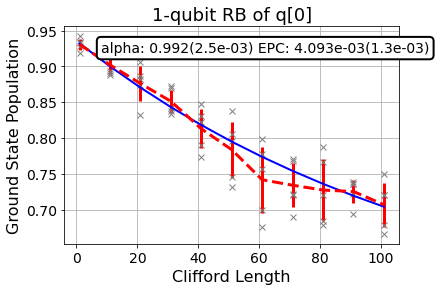

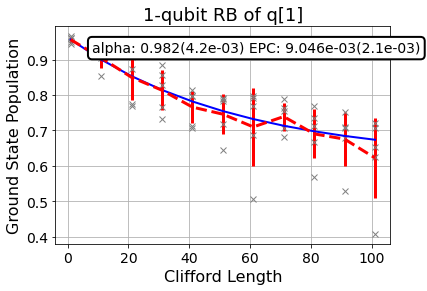

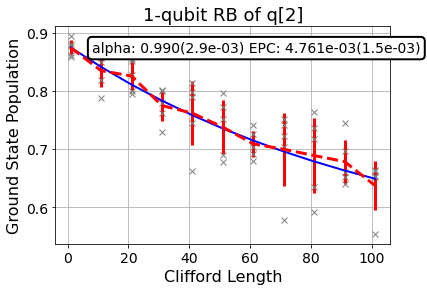

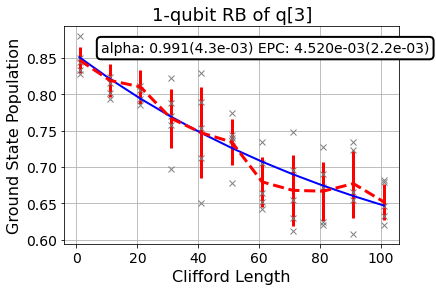

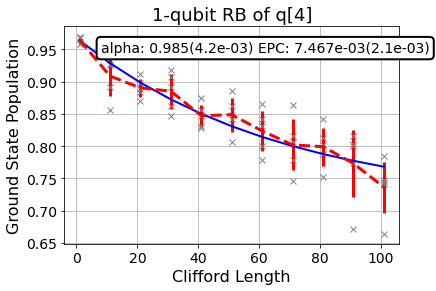

In [5]:
for qubit in qubits_1qRB:
    rbfit = rb.fitters.RBFitter(complete_result_list[qubit], xdata, rb_params_list[qubit]['rb_pattern']) # number of results must match xdata length
    
    plt.figure()
    plot = plt.gca()
    for i in range(len(rb_params_list[qubit]['rb_pattern'])):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=plot, add_label=True, show_plt=False)

        # Add title and label
        plot.set_title('{}-qubit RB of q{}'.format(len(rb_params_list[qubit]['rb_pattern'][i]), str(rb_params_list[qubit]['rb_pattern'][i])), fontsize=18)

### Average gate error

In [6]:
for i, qubit in enumerate(qubits_1qRB):
    gates_per_cliff = rb.rb_utils.gates_per_clifford(complete_transpile_list[i],xdata[0],starmon5_natives,rb_params_list[i]['rb_pattern'][0])
    total = 0
    for basis_gate in starmon5_natives:
        total += gates_per_cliff[i][basis_gate]
        print('Average number of {0} gates per Clifford: {1}'.format(basis_gate,
                                                      np.mean(gates_per_cliff[i][basis_gate])))
    print('------------------------------------------')
    print('Average total number of gates per Clifford: {0} \n'.format(total))

Average number of id gates per Clifford: 0.0
Average number of x gates per Clifford: 0.044755244755244755
Average number of y gates per Clifford: 0.043706293706293704
Average number of rx gates per Clifford: 0.3083916083916084
Average number of ry gates per Clifford: 0.5660839160839161
Average number of rz gates per Clifford: 0.8055944055944056
Average number of cz gates per Clifford: 0.0
------------------------------------------
Average total number of gates per Clifford: 1.7685314685314686 

Average number of id gates per Clifford: 0.0
Average number of x gates per Clifford: 0.03426573426573427
Average number of y gates per Clifford: 0.04825174825174825
Average number of rx gates per Clifford: 0.3384615384615385
Average number of ry gates per Clifford: 0.5265734265734265
Average number of rz gates per Clifford: 0.7727272727272727
Average number of cz gates per Clifford: 0.0
------------------------------------------
Average total number of gates per Clifford: 1.7202797202797202 

Av

# 2-qubit RB of Starmon-5

In [15]:
complete_result_list_2qRB = []
complete_transpile_list_2qRB = []
rb_params_list_2qRB = []
     
shots = 500
qubits_2qRB = [[2,0],[2,1],[2,3],[2,4]]

for qubits in qubits_2qRB:
    # Create benchmarking sequences for qubit
    rb_params = {}
    rb_params['length_vector'] = np.arange(1,22,2)   # number of Cliffords in the sequence (start, stop, steps)
    rb_params['nseeds'] = 5                          # number of seeds, i.e. random sequences    
    rb_params['rb_pattern'] = [qubits]               # for simultaneus rb, use [[q0,q1],[q2],...,[qi]]
    rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_params)
    
    # Prepare lists for transpiled circuits and benchmark results
    result_list = []
    transpile_list = []
    
    # Compile and run benchmarks
    for rb_seed, rb_circ_seed in enumerate(rb_circs):
        print(str(datetime.now())[:19]+': Compiling seed {}'.format(rb_seed))
        rb_circ_transpile = transpile(rb_circ_seed, basis_gates=starmon5_natives)
        
        job_count = 0
        for rb_circ_transpile_clif in rb_circ_transpile:
            print(str(datetime.now())[:19]+': Running seed {}, job {}'.format(rb_seed, job_count))
            qi_job = execute(rb_circ_transpile_clif, backend=qi_starmon5_backend, shots=shots)
            result_list.append(qi_job.result())
            transpile_list.append(rb_circ_transpile)
            job_count += 1
    
    # Store result for tested qubit
    print(str(datetime.now())[:19]+': All seeds complete')
    complete_result_list_2qRB.append(result_list)
    complete_transpile_list_2qRB.append(transpile_list)
    rb_params_list_2qRB.append(rb_params)

2021-05-12 08:54:21: Compiling seed 0
2021-05-12 08:54:26: Running seed 0, job 0
2021-05-12 10:07:10: Running seed 0, job 1
2021-05-12 10:10:08: Running seed 0, job 2
2021-05-12 10:12:25: Running seed 0, job 3
2021-05-12 10:14:43: Running seed 0, job 4
2021-05-12 10:17:06: Running seed 0, job 5
2021-05-12 10:19:47: Running seed 0, job 6
2021-05-12 10:22:29: Running seed 0, job 7
2021-05-12 10:25:17: Running seed 0, job 8
2021-05-12 10:28:03: Running seed 0, job 9
2021-05-12 10:30:56: Running seed 0, job 10
2021-05-12 10:33:43: Compiling seed 1
2021-05-12 10:33:48: Running seed 1, job 0
2021-05-12 10:36:30: Running seed 1, job 1
2021-05-12 10:39:12: Running seed 1, job 2
2021-05-12 10:41:59: Running seed 1, job 3
2021-05-12 10:44:52: Running seed 1, job 4
2021-05-12 10:48:18: Running seed 1, job 5
2021-05-12 10:51:35: Running seed 1, job 6
2021-05-12 10:54:50: Running seed 1, job 7
2021-05-12 10:58:12: Running seed 1, job 8
2021-05-12 11:01:28: Running seed 1, job 9
2021-05-12 11:04:43:

2021-05-12 18:26:22: Running seed 0, job 9
2021-05-12 18:29:48: Running seed 0, job 10
2021-05-12 18:32:40: Compiling seed 1
2021-05-12 18:32:45: Running seed 1, job 0
2021-05-12 18:35:57: Running seed 1, job 1
2021-05-12 18:39:13: Running seed 1, job 2
2021-05-12 18:42:06: Running seed 1, job 3
2021-05-12 18:45:28: Running seed 1, job 4
2021-05-12 18:48:49: Running seed 1, job 5
2021-05-12 18:52:01: Running seed 1, job 6
2021-05-12 18:55:28: Running seed 1, job 7
2021-05-12 18:58:43: Running seed 1, job 8
2021-05-12 19:02:11: Running seed 1, job 9
2021-05-12 19:05:22: Running seed 1, job 10
2021-05-12 19:08:39: Compiling seed 2
2021-05-12 19:08:44: Running seed 2, job 0
2021-05-12 19:11:31: Running seed 2, job 1
2021-05-12 19:14:53: Running seed 2, job 2
2021-05-12 19:18:09: Running seed 2, job 3
2021-05-12 19:21:37: Running seed 2, job 4
2021-05-12 19:24:48: Running seed 2, job 5
2021-05-12 19:28:15: Running seed 2, job 6
2021-05-12 19:31:03: Running seed 2, job 7
2021-05-12 19:33:23

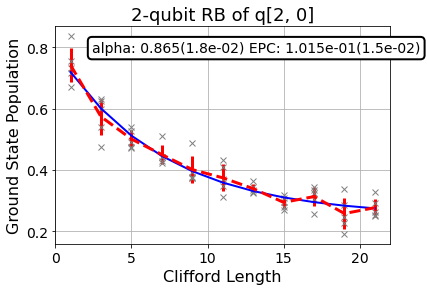

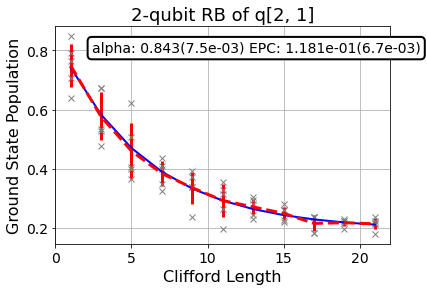

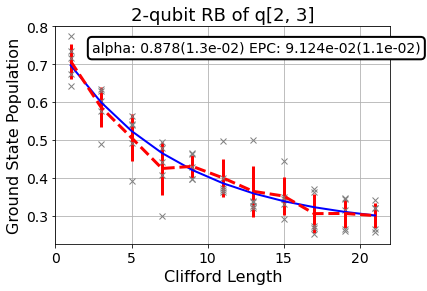

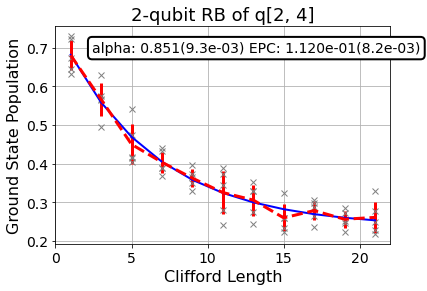

In [16]:
for qubit,_ in enumerate(qubits_2qRB):
    rbfit = rb.fitters.RBFitter(complete_result_list_2qRB[qubit], xdata, rb_params_list_2qRB[qubit]['rb_pattern']) # number of results must match xdata length
    
    plt.figure()
    plot = plt.gca()
    for i in range(len(rb_params_list_2qRB[qubit]['rb_pattern'])):
        pattern_ind = i

        # Plot the essence by calling plot_rb_data
        rbfit.plot_rb_data(pattern_ind, ax=plot, add_label=True, show_plt=False)

        # Add title and label
        plot.set_title('{}-qubit RB of q{}'.format(len(rb_params_list_2qRB[qubit]['rb_pattern'][i]), str(rb_params_list_2qRB[qubit]['rb_pattern'][i])), fontsize=18)

In [12]:
rb_params_list_2qRB

[{'length_vector': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
  'nseeds': 5,
  'rb_pattern': [[2, 0]]},
 {'length_vector': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
  'nseeds': 5,
  'rb_pattern': [[2, 1]]},
 {'length_vector': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
  'nseeds': 5,
  'rb_pattern': [[2, 3]]},
 {'length_vector': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
  'nseeds': 5,
  'rb_pattern': [[2, 4]]}]

In [14]:
i = 2
gates_per_cliff = rb.rb_utils.gates_per_clifford(complete_transpile_list_2qRB[i],xdata[0],starmon5_natives,rb_params_list_2qRB[i]['rb_pattern'][0])
gates_per_cliff

{2: {'id': 0.0,
  'x': 0.0,
  'y': 0.0030303030303030303,
  'rx': 1.2393939393939395,
  'ry': 1.4712121212121212,
  'rz': 2.1484848484848484,
  'cz': 2.775757575757576},
 3: {'id': 0.0,
  'x': 0.0015151515151515152,
  'y': 0.0,
  'rx': 2.221212121212121,
  'ry': 1.0712121212121213,
  'rz': 1.6545454545454545,
  'cz': 2.775757575757576}}

In [11]:
for i, qubit in enumerate(qubits_2qRB):
    gates_per_cliff = rb.rb_utils.gates_per_clifford(complete_transpile_list_2qRB[i],xdata[0],starmon5_natives,rb_params_list_2qRB[i]['rb_pattern'][0])
    total = 0
    for basis_gate in starmon5_natives:
        total += gates_per_cliff[i][basis_gate]
        print('Average number of {0} gates per Clifford: {1}'.format(basis_gate,
                                                      np.mean(gates_per_cliff[i][basis_gate])))
    print('------------------------------------------')
    print('Average total number of gates per Clifford: {0} \n'.format(total))

Average number of id gates per Clifford: 0.0
Average number of x gates per Clifford: 0.0
Average number of y gates per Clifford: 0.0
Average number of rx gates per Clifford: 2.2181818181818183
Average number of ry gates per Clifford: 1.0696969696969696
Average number of rz gates per Clifford: 1.9257575757575758
Average number of cz gates per Clifford: 2.915151515151515
------------------------------------------
Average total number of gates per Clifford: 8.128787878787879 

Average number of id gates per Clifford: 0.0
Average number of x gates per Clifford: 0.0015151515151515152
Average number of y gates per Clifford: 0.0
Average number of rx gates per Clifford: 2.4106060606060606
Average number of ry gates per Clifford: 0.9333333333333333
Average number of rz gates per Clifford: 1.7924242424242425
Average number of cz gates per Clifford: 3.003030303030303
------------------------------------------
Average total number of gates per Clifford: 8.14090909090909 

Average number of id gate

KeyError: 3